<a href="https://colab.research.google.com/github/Pepe-Padilla/deep-learning/blob/main/lateFusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Late Fusion - DeepLearning


### Indice
1. Introducción
2. Importación y Normalización de datos
3. Entrenamiento
4. Gráfica de Perdidas
5. Test
6. Concluciones

##  1. Introducción

**Práctica DL** - Ejercicio de Bootcamp Inteligencia Artificial Full Stack Edición III

Este proyecto es un entregable para la práctica del Master Bootcamp Inteligencia Artificial Full Stack Edición III realizado por el centro de formación [@Keepcoding](https://github.com/KeepCoding)

---

El objetivo de este trabajo consiste en resolver un problema del mundo real empleando para ello técnicas vistas durante las sesiones de dicho módulo. En concreto, se trabajará en predecir la condición médica sufrida por una cohorte de pacientes a partir de las diferentes fuentes de información disponibles (imágenes y datos tabulares).

Las imagenes deben entrenar y obtener una de los siguientes respuestas:

| Enfermedad | Descripción | Código | Indice en salida |
|------------|-------------|--------|------------------|
| Actinic keratoses y carcinoma de células escamosas | Tipo de cáncer de piel | akiec | 0 |
| Nevus melanocítico | Lesión benigna común | nv | 1 |
| Melanoma | Tipo de cáncer de piel agresivo | mel | 2 |
| Lesiones benignas de queratosis | Incluyen lentigo solar y queratosis seborreica | bkl | 3 |
| Dermatofibroma | Lesión benigna del tejido fibroso | df | 4 |
| Vasculares | Lesiones vasculares como hemangiomas | vasc | 5 |
| Lesión de células basales | Un tipo de cáncer de piel menos agresivo que el melanoma | bcc | 6 |

---

Para el Late Fusion se usará la combinación aprendida de las predicciones realizadas por el modelo 1D y 2D desarrollado previamente.

## 2. Importación y Normalización de datos

### 2.1 Imports

In [ ]:
# 1. Primero las importaciones que necesitaremos
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate

### 2.2 Obtención de datos

In [ ]:
# 2. Obtención de datos
#dataframe = pd.read_csv("/content/HAM10000_metadata.csv", usecols=[1], engine='python', skipfooter=3)
#df = dataframe.values
df_label = pd.read_csv("/content/HAM10000_metadata.csv", sep=",")
df_image = pd.read_csv("/content/hnmist_28_28_RGB.csv", sep=",")
tabular_model = tf.keras.models.load_model("/content/1d_model.keras")
image_model = tf.keras.models.load_model("/content/2d_model.keras")


### 2.3 Inspección de elementos

In [ ]:
# 2. Inspección de los datos
print(df_image.head())
print(df_image.info())
print(df_label.head())
print(df_label.info())

# 3. Preprocesamiento
# Separación de características e imágenes
X = df_image.values  # Extraemos los valores de píxeles
X = X.reshape(-1, 28, 28, 3)  # Reestructuramos a formato de imagen (28x28x3)
X = X.astype(np.float32) / 255.0  # Normalización de valores RGB
y_coll = df_label['dx']  # Extraemos las etiquetas de diagnóstico

# One-Hot Encoding para la variable de salida
y = pd.get_dummies(y_coll).values



   pixel0000  pixel0001  pixel0002  pixel0003  pixel0004  pixel0005  \
0        192        153        193        195        155        192   
1         25         14         30         68         48         75   
2        192        138        153        200        145        163   
3         38         19         30         95         59         72   
4        158        113        139        194        144        174   

   pixel0006  pixel0007  pixel0008  pixel0009  ...  pixel2342  pixel2343  \
0        197        154        185        202  ...        134        173   
1        123         93        126        158  ...         82         60   
2        201        142        160        206  ...        149        167   
3        143        103        119        171  ...         73         44   
4        215        162        191        225  ...        201        209   

   pixel2344  pixel2345  pixel2346  pixel2347  pixel2348  pixel2349  \
0        124        138        183        147

### 2.4 Separación de datos

In [ ]:
# 4. Separación de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, shuffle=True, test_size=0.15, random_state=42)

# 5. Verificación de normalización
print("Rango de valores normalizados en X:", X_train.min(), "a", X_train.max())
print("Formato de salida Y:", y_train.shape)

Rango de valores normalizados en X: 0.0 a 1.0
Formato de salida Y: (6810, 7)


### 2.5 Verificación

In [ ]:
# 5. Verificación de normalización
y_traindf = pd.DataFrame(y_train)

print(y_traindf.describe())
print(X_train.shape)

            0      1      2      3      4     5      6
count    6810   6810   6810   6810   6810  6810   6810
unique      2      2      2      2      2     2      2
top     False  False  False  False  False  True  False
freq     6583   6455   6079   6734   6063  4566   6702
(6810, 28, 28, 3)


## 3. Entrenamiento

In [ ]:
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.constraints import max_norm

# 6. Definición del modelo CNN con Dropout
P = 0.20
n_epochs = 50
model = Sequential()

model.add(Conv2D(128, kernel_size=(3, 3), input_shape=(28, 28, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(P))

# Definimos una segunda capa convolucional
model.add(Conv2D(128, kernel_size=(3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(P))

# Definimos una tercera capa convolucional
model.add(Conv2D(128, kernel_size=(3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(P))

# Añadimos nuestro clasificador
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu', kernel_constraint=max_norm(3.0)))
model.add(Dropout(P))
model.add(Dense(y.shape[1], activation='softmax'))

# Compilamos el modelo
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(1e-4),
              metrics=['accuracy'])

# 8. Entrenamiento del modelo
H = model.fit(X_train, y_train,
          batch_size=128,
          shuffle=True,
          epochs=n_epochs,
          validation_data=(X_val, y_val))

# 9. Evaluación del modelo
scores = model.evaluate(X_test, y_test)
print('Loss: %.3f' % scores[0])
print('Accuracy: %.3f' % scores[1])




Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 141ms/step - accuracy: 0.5731 - loss: 1.2569 - val_accuracy: 0.6664 - val_loss: 1.6865
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6847 - loss: 0.8969 - val_accuracy: 0.6606 - val_loss: 1.6614
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7001 - loss: 0.8387 - val_accuracy: 0.2987 - val_loss: 1.7084
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7062 - loss: 0.7977 - val_accuracy: 0.1389 - val_loss: 1.8147
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7097 - loss: 0.7868 - val_accuracy: 0.1215 - val_loss: 1.8286
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7157 - loss: 0.7598 - val_accuracy: 0.1339 - val_loss: 1.7523
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7200 - loss: 0.7588 - val_accuracy: 0.1772 - val_loss: 1.6638
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7310 - loss: 0.7282 - val_accuracy: 0.2870 -

## 4. Gráfica de Perdidas

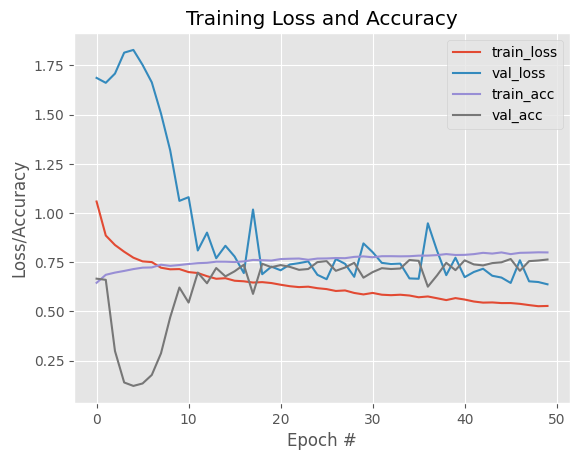

In [ ]:
# veamos nuestra función de pérdidas con respecto a las épocas ejecutadas
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, n_epochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, n_epochs), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, n_epochs), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, n_epochs), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [ ]:
# Guardamos el resultado
model.save("/content/2d_model.h5")
model.save("/content/2d_model.keras")

## 5. Concluciones

In [ ]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)                   │ (None, 26, 26, 128)         │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 26, 26, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_13 (Activation)           │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 13, 13, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 13, 13, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 11, 11, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 11, 11, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_14 (Activation)           │ (None, 11, 11, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 5, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 5, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 3, 3, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 3, 3, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_15 (Activation)           │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1024)                │         132,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 7)                   │           7,175 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 1,317,143 (5.02 MB)

 Trainable params: 438,791 (1.67 MB)

 Non-trainable params: 768 (3.00 KB)

 Optimizer params: 877,584 (3.35 MB)

El objetivo para esta parte del modelo 2D era la predicicón con imagenes, Se utilizó una red neuronal convolucional (CNN). En particular, se implementó una arquitectura con múltiples capas convolucionales seguidas de Batch Normalization, ReLU y Dropout para mejorar la capacidad de generalización y evitar el overfitting. Usé el GlobalAveragePooling2D para reducir la dimensionalidad antes de la capa densa final, mejorando la eficiencia computacional. Al igual que con 1D ReLU com función no líneal para mantener el rango entre 0 y 1.

El modelo mostró una tendencia esperada en la gráfica de loss y accuracy, aunque se observaron picos anómalos en ambas métricas. Puede ser por el tamaño del batch o por el tamaño de la muestra, también podría ser por la taza de aprendizaje (aunque use una pequeña)

Si se dispusiera de más tiempo, se podrían aplicar los siguientes enfoques:

Tamaño del Batch Ajustado: Probar valores más pequeños (como 64 o 32) para reducir la variabilidad de cada batch. Implementar una estrategia de reducción de la tasa de aprendizaje cuando la loss deje de mejorar. Además de Dropout, podría incluir una penalización en los pesos para evitar Overfitting.

En general, la implementación de CNN con Dropout ha sido efectiva, aunque con más recursos y ajustes podría mejorar aún más su precisión y estabilidad.